# Preprocessing

## Imports & Setup

In [1]:
# Data Manipulation
import os
import numpy as np
import pandas as pd

#Image Processing
import cv2
import glob
import pydicom

#Data Visulaization
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## Configuration

In [2]:
# --- CONFIGURATION ---
conf = {
    'ROOT_DIR': '/kaggle/input/rsna-breast-cancer-detection',
    'SAVE_DIR': '/kaggle/working/processed_images',
    'IMG_HEIGHT': 1024,
    'IMG_WIDTH': 512,
    'N_CORES': 4  # Kaggle usually gives 2-4 cores. Set to -1 to use all.
}

# Create directory if it doesn't exist
os.makedirs(conf['SAVE_DIR'], exist_ok=True)

# Load Train CSV
df = pd.read_csv(f"{conf['ROOT_DIR']}/train.csv")
print(f"Dataset Loaded: {df.shape[0]} images.")

# Add full path to the dataframe for easy access
def get_image_path(patient_id, image_id):
    return f"{conf['ROOT_DIR']}/train_images/{patient_id}/{image_id}.dcm"

df['path'] = df.apply(lambda x: get_image_path(x.patient_id, x.image_id), axis=1)
df.head()

Dataset Loaded: 54706 images.


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...


In [3]:
# Check cancer distribution
print(f"\nCancer distribution:")
print(df['cancer'].value_counts())
print(f"Cancer rate: {df['cancer'].mean():.4f}")


Cancer distribution:
cancer
0    53548
1     1158
Name: count, dtype: int64
Cancer rate: 0.0212


In [8]:
#plot one patient of data and its all images
def plot_patient_images(patient_id):
    patient_df = df[df['patient_id'] == patient_id]
    images = []
    for _, row in patient_df.iterrows():
        dcm = pydicom.dcmread(row['path'])
        img = dcm.pixel_array
        #img = cv2.resize(img, (conf['IMG_WIDTH'], conf['IMG_HEIGHT']))
        images.append(img)
    
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for ax, img, row in zip(axes, images, patient_df.itertuples()):
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Image ID: {row.image_id}\nCancer: {row.cancer}")
        ax.axis('off')
    plt.show()

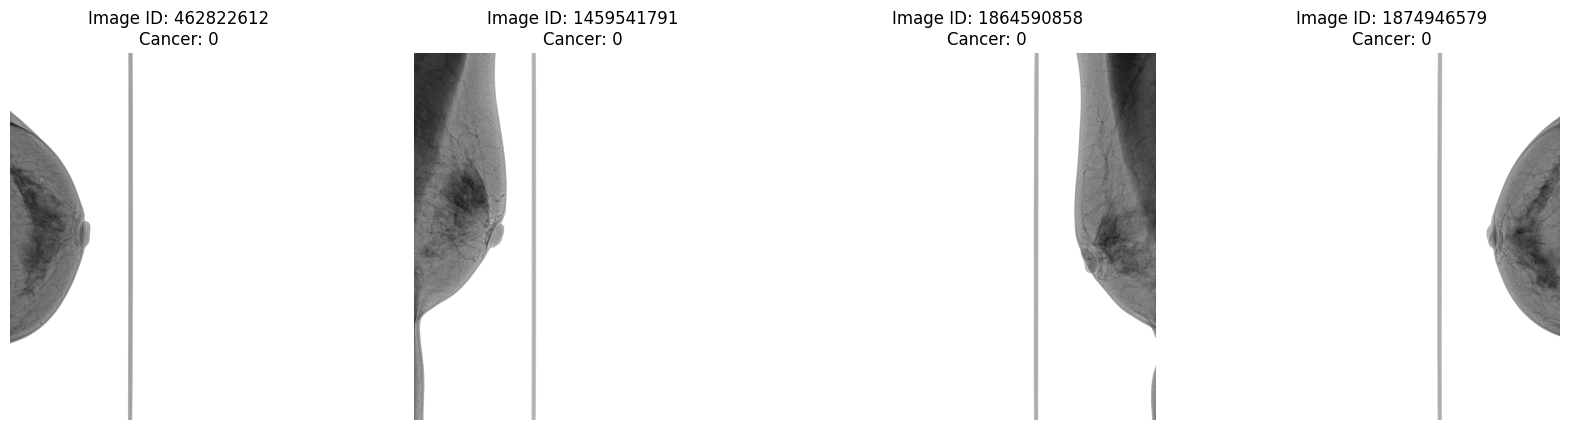

In [9]:
plot_patient_images(df['patient_id'].iloc[0])  # Plot images for the first patient in the dataset

In [12]:
# Get class names from subdirectory names
classes = df['cancer'].unique().tolist()
classes.sort()
print("Classes:", classes)

# Initialize lists to hold file paths and labels
file_paths = df['path'].tolist()
labels = df['cancer'].tolist()

Classes: [0, 1]


In [10]:
# Map class names to numerical labels
class_to_label = {class_name: idx for idx, class_name in enumerate(classes)}
print("Class to label mapping:", class_to_label)

Class to label mapping: {0: 0, 1: 1}


Class counts:
 class_name
0    53548
1     1158
Name: count, dtype: int64


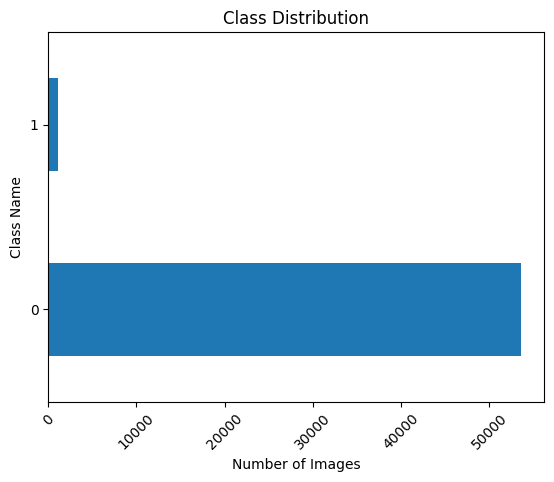

In [13]:
# Create a DataFrame to aid in analysis
data = pd.DataFrame({
    'image_path': file_paths,
    'label': labels
})

# Map numerical labels to class names
label_to_class = {v: k for k, v in class_to_label.items()}
data['class_name'] = data['label'].map(label_to_class)

# Display class counts
class_counts = data['class_name'].value_counts()
print("Class counts:\n", class_counts)

# Plot class distribution
class_counts.plot(kind='barh')
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Class Name')
plt.xticks(rotation=45)
plt.show() 

In [ ]:

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.countplot(data=data, x=data['label'].map(label_to_class), palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.title("Count of Each Category")
plt.xlabel("Category")
plt.ylabel("Count")

plt.show()

NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

## Preprocessing Functions

In [4]:
!pip install -qU dicomsdl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.6 MB/s eta 0:00:0000:01


In [5]:
import dicomsdl

def read_dicom(path):
    """
    Reads a DICOM file using dicomsdl (Faster & more robust than pydicom).
    """
    try:
        # 1. Open with dicomsdl
        dcm = dicomsdl.open(path)
        img = dcm.pixelData()
        
        # 2. Photometric Interpretation
        # If MONOCHROME1, the image is inverted (Bone is black, Air is white).
        # We want MONOCHROME2 (Bone/Tissue is white).
        # dicomsdl accesses metadata via getPixelDataInfo() or direct attributes
        info = dcm.getPixelDataInfo()
        if info['PhotometricInterpretation'] == "MONOCHROME1":
            img = np.max(img) - img
            
        # 3. Normalize to 0-255 (8-bit)
        if np.max(img) != 0:
            img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255.0
        
        return img.astype(np.uint8)
    
    except Exception as e:
        # If dicomsdl fails, we print but don't crash
        print(f"Error reading {path}: {e}")
        return None

def crop_breast(img):
    if img is None: return None # Safety Check
    
    # 1. Binarize
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 2. Find Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours: return img
    
    # 3. Crop to largest contour
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    return img[y:y+h, x:x+w]

def process_single_image(path, save_dir, img_height, img_width):
    # Extract IDs
    parts = path.split('/')
    patient_id = parts[-2]
    image_id = parts[-1].replace('.dcm', '')
    filename = f"{patient_id}_{image_id}.png"
    save_path = os.path.join(save_dir, filename)
    
    # Logic
    img = read_dicom(path)
    if img is None: return None
    
    img = crop_breast(img)
    if img is None: return None
    
    # Resize
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_LINEAR)
    
    # Save
    cv2.imwrite(save_path, img)
    
    return filename

## Visualization (Sanity Check)

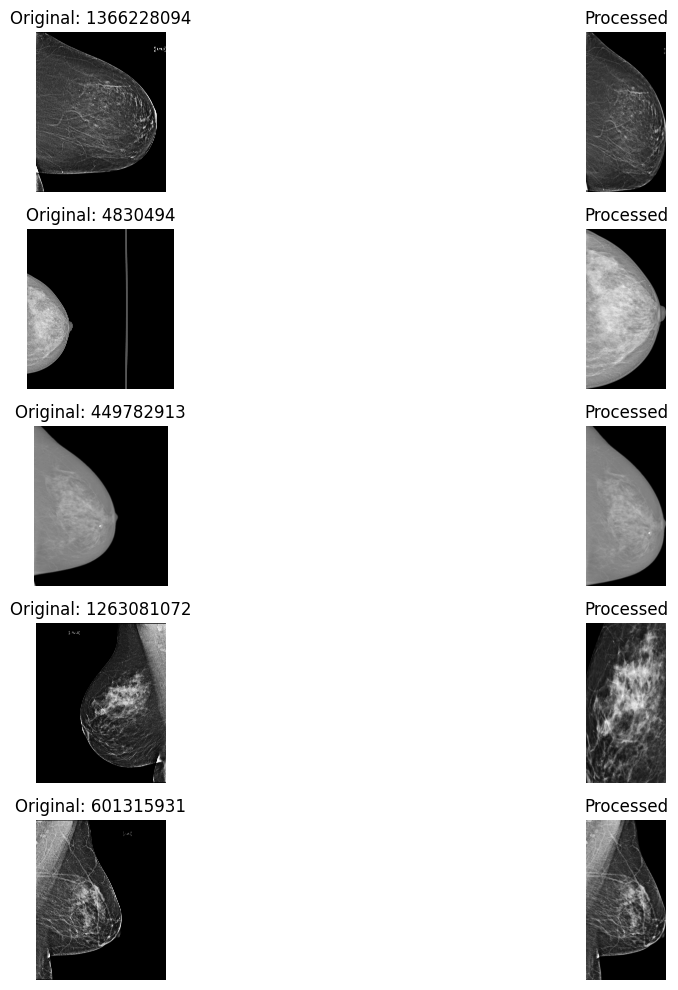

In [6]:
# Select 5 random images
sample_df = df.sample(5)

plt.figure(figsize=(15, 10))

plot_idx = 0
for i, (_, row) in enumerate(sample_df.iterrows()):
    # 1. Load Original
    original = read_dicom(row.path)
    
    # Safety Check: If image failed to load, skip it
    if original is None:
        continue
        
    # 2. Process
    cropped = crop_breast(original)
    final = cv2.resize(cropped, (conf['IMG_WIDTH'], conf['IMG_HEIGHT']))
    
    # 3. Plot
    plot_idx += 1
    plt.subplot(5, 2, 2*plot_idx - 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original: {row.image_id}")
    plt.axis('off')
    
    plt.subplot(5, 2, 2*plot_idx)
    plt.imshow(final, cmap='gray')
    plt.title(f"Processed")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Prepare inputs for parallel function
paths = df['path'].tolist()

# Run Parallel Processing
# Returns a list of filenames if successful, or None if failed
print(f"Starting processing of {len(paths)} images on {conf['N_CORES']} cores...")

results = Parallel(n_jobs=conf['N_CORES'], backend='threading')(
    delayed(process_single_image)(
        path, 
        conf['SAVE_DIR'], 
        conf['IMG_HEIGHT'], 
        conf['IMG_WIDTH']
    ) 
    for path in tqdm(paths)
)

print("Processing Complete!")

Starting processing of 54706 images on 4 cores...


  0%|          | 0/54706 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Feature Engineering

In this section, we will extract additional features from the dataset, such as patient-level statistics or image metadata, to enhance the dataset for predictive modeling.

In [ ]:
# Feature Engineering: Add patient-level statistics
# Example: Count the number of images per patient

df['image_count'] = df.groupby('patient_id')['image_id'].transform('count')

# Example: Add metadata (if available) from DICOM files
def extract_metadata(path):
    try:
        dcm = dicomsdl.open(path)
        return {
            'PatientAge': dcm.getValue('PatientAge', default=None),
            'PatientSex': dcm.getValue('PatientSex', default=None),
        }
    except Exception as e:
        print(f"Error extracting metadata from {path}: {e}")
        return {'PatientAge': None, 'PatientSex': None}

metadata = df['path'].apply(extract_metadata)
metadata_df = pd.DataFrame(metadata.tolist())
df = pd.concat([df, metadata_df], axis=1)

print("Feature engineering complete!")

## Data Splitting

We will split the dataset into training, validation, and test sets to prepare for model training.

In [ ]:
# Split the dataset into training, validation, and test sets
from sklearn.model_selection import train_test_split

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Perform the split
train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), random_state=42, stratify=df['cancer'])
val_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, stratify=temp_df['cancer'])

print(f"Training set: {train_df.shape[0]} samples")
print(f"Validation set: {val_df.shape[0]} samples")
print(f"Test set: {test_df.shape[0]} samples")

## Save Processed Data

Finally, we will save the processed dataset (CSV) with paths to the preprocessed images for future use.

In [ ]:
# Save the processed datasets
train_df.to_csv(f"{conf['SAVE_DIR']}/train_processed.csv", index=False)
val_df.to_csv(f"{conf['SAVE_DIR']}/val_processed.csv", index=False)
test_df.to_csv(f"{conf['SAVE_DIR']}/test_processed.csv", index=False)

print("Processed datasets saved!")